In [1]:
# !clear
# !pip install pytorch-lightning
# !pip install torch-geometric

In [1]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from pygcn.utils import load_data, accuracy

from pygcn.models import GCN

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

In [4]:
import dgl

In [64]:
dataset = dgl.data.CoraGraphDataset(raw_dir=f'datasets/Cora/')

datasets/Cora/cora_v2.zip: 100%|██████████| 132k/132k [00:00<00:00, 1.45MB/s]


Extracting file to datasets/Cora/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [65]:
g = dataset[0]

In [66]:
g.edges() 

(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

In [67]:
class MySampler(dgl.dataloading.Sampler):
    def __init__(self):
        super().__init__()

    def sample(self, g, indices):
        return g

In [68]:
dataloader = dgl.dataloading.DataLoader(g, torch.arange(3), MySampler(),
                                        batch_size=128, shuffle=False, drop_last=False, num_workers=4)
batch = next(iter(dataloader))

/opt/conda/envs/sheaf/lib/python3.11/site-packages/dgl/dataloading/dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


In [74]:
for name in ["train_mask", "val_mask", "test_mask"]:
    print(name, g.ndata[name].sum())

train_mask tensor(140)
val_mask tensor(500)
test_mask tensor(1000)


In [71]:
batch.ndata["feat"]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [3]:
class CORA_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super(CORA_Dataset).__init__()
        # self.data = Planetoid(root='./cora/', name='cora')[0]
        self.data = Planetoid(root='datasets/cora/', name='cora')[0]

        # scaler = StandardScaler()
        # self.data.x[self.data.train_mask] = torch.FloatTensor(scaler.fit_transform(self.data.x[self.data.train_mask]))
        # self.data.x[self.data.val_mask] = torch.FloatTensor(scaler.transform(self.data.x[self.data.val_mask]))
        # self.data.x[self.data.test_mask] = torch.FloatTensor(scaler.transform(self.data.x[self.data.test_mask]))

        # self.data.x = self.data.x.to(torch.float32)
        

        
    def __len__(self):
        return 1
    
    
    def __getitem__(self, idx):
        return self.data.x, self.data.edge_index, self.data.y,\
               self.data.train_mask | self.data.val_mask, self.data.test_mask
    
dataset = CORA_Dataset()
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
from sklearn.decomposition import PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygcn.datasets import SheafDataset

In [2]:
dataset = SheafDataset("cora")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
X = dataset.data[0].ndata['feat'].numpy()

Text(0, 0.5, 'cumulative explained variance')

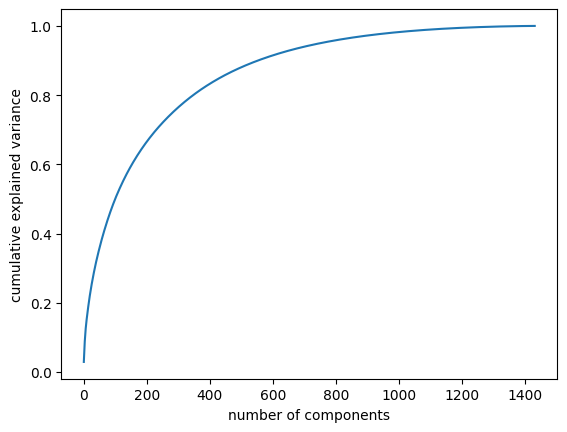

In [6]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
S = np.cumsum(pca.explained_variance_ratio_)
d = 0
while S[d] < S[-1] * 0.95:
    d += 1
d + 1

752

In [6]:
torch.__version__

'2.2.0'

In [7]:
from torch_geometric.loader import NeighborLoader

In [16]:
loader = NeighborLoader(
    dataset.data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[10] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    input_nodes=dataset.data.train_mask,
)

for i in loader:
    print(i)
    break

Data(x=[1252, 1433], edge_index=[2, 2555], y=[1252], train_mask=[1252], val_mask=[1252], test_mask=[1252], n_id=[1252], e_id=[2555], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[128], batch_size=128)


In [15]:
i.

SyntaxError: invalid syntax (3923724551.py, line 1)

In [17]:
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
deg = degree(dataset.data.edge_index[1], dataset.data.x.size(0))

In [ ]:
from collections import Counter

num = 15
cnt = np.array(Counter(deg.numpy().astype(int)).most_common(num))
plt.bar(cnt[:, 0], cnt[:, 1])

In [ ]:
# def kNN(x, i, local_nbhood, k):
#     dists = cdist([x[i].numpy()], x)[0]
#     dists[local_nbhood] = np.inf
#     ind = dists.argsort()[:k]
#     return torch.tensor(ind)

In [ ]:
def build_sheaf_laplacian(dataset, d, is_self_loops=True):
    x, edge_index, _, _, _ = dataset[0]

    n = x.size(1)
    
    O_matrices = torch.empty(x.size(0), n, d)

    dists = cdist(x, x)
    
    for i in tqdm(range(x.size(0))):
        local_nbhood = k_hop_subgraph(i, 1, edge_index, relabel_nodes=False)[0]
        if len(local_nbhood) != d:
            dists_i = dists[i].copy()
            if len(local_nbhood) < d:
                dists_i[local_nbhood] = np.inf
            else:
                dists_i[~local_nbhood] = np.inf
            ind = dists_i.argsort()[: d if len(local_nbhood) > d else d - local_nbhood.size(0)]
            nearests = torch.tensor(ind)
            if local_nbhood.size(0) < d:
                local_nbhood = torch.concat([local_nbhood, nearests])
            else:
                local_nbhood = nearests
            


        # if len(local_nbhood) < d:
        #     dists_i = dists[i].copy()
        #     dists_i[local_nbhood] = np.inf
        #     ind = dists_i.argsort()[:d - local_nbhood.size(0)]
        #     nearests = torch.tensor(ind) # kNN(x, i, local_nbhood, k=d-len(local_nbhood))
        #     local_nbhood = torch.concat([local_nbhood, nearests])
        # elif len(local_nbhood) > d:
        #     local_nbhood = local_nbhood[local_nbhood != i][:d]


        # print(x[local_nbhood].size())
        U, _, _ = np.linalg.svd(x[local_nbhood].T) 
        # print(U.shape)
        O_matrices[i] = torch.from_numpy(U[:, :d]) # n x d
        
    sheaf_laplacian = torch.empty(edge_index.size(1), n, n)
        
    for k in tqdm(range(edge_index.size(1))):
        i, j = edge_index[:, k]
        mul = torch.matmul(O_matrices[i], O_matrices[j].T) # n x n
        U, _, V_T = np.linalg.svd(mul)
        sheaf_laplacian[k] = torch.tensor(np.dot(U, V_T))
        
    if is_self_loops:
        self_laplac = torch.concat([torch.eye(n).unsqueeze(0) for _ in range(x.size(0))])
        sheaf_laplacian = torch.concat([sheaf_laplacian, self_laplac], axis=0)
        
    return sheaf_laplacian
    
        
        

In [18]:
nfeat = dataset.data.x.size(1)
hidden = 16 #16
nclass = dataset.data.y.max().item() + 1
dropout = 0.5
# sheaf_laplacian = build_sheaf_laplacian(dataset, hidden).to(torch.float32)

weight_decay = 5e-4

In [ ]:
torch.save(sheaf_laplacian, f'weights/sheaf_laplacian_cora_{hidden}.pt')

In [ ]:
# sheaf_laplacian = torch.load('sheaf_laplacian.pt')

In [19]:
device = "cpu"

In [28]:
class GCN_module(pl.LightningModule):
    def __init__(self, learning_rate=0.01):
        super(GCN_module, self).__init__()
        self.model = GCN(nfeat=nfeat,
                         nhid=hidden,
                         nclass=nclass,
                         dropout=dropout,
                         sheaf_laplacian=None)
        self.model.to(device)
        
        self.learning_rate = learning_rate
        self.loss_fn = F.nll_loss
        
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate,
                           weight_decay=weight_decay)
        return optim
    
    def forward(self, features, adj):
        return self.model(features, adj)
    
    
    def training_step(self, train_batch, batch_idx):
        print(train_batch)
        x, edge_index, y, train_mask, val_mask = train_batch
        x, edge_index, y = x[0], edge_index[0], y[0]
        train_mask, val_mask = train_mask[0], val_mask[0]
        
        output = self.model(x, edge_index)
        
        loss_train = self.loss_fn(output[train_mask], y[train_mask])
        acc_train = accuracy(output[train_mask], y[train_mask])
        
        loss_val = self.loss_fn(output[val_mask], y[val_mask])
        acc_val = accuracy(output[val_mask], y[val_mask])
        
        self.log("loss_train", loss_train, prog_bar=True)
        self.log("acc_train", acc_train, prog_bar=True)
        
        self.log("loss_val", loss_val, prog_bar=True)
        self.log("acc_val", acc_val, prog_bar=True)
        
        return loss_train
        
    def validation_step(self, val_batch, batch_idx):
        pass
        

In [29]:
# !rm -r lightning_logs

In [30]:
# checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="acc_val", mode="max")

trainer = pl.Trainer(max_epochs=400, accelerator=device)#, callbacks=checkpoint_callback, )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
module = GCN_module().to(device)

trainer.fit(module, loader, loader)


  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 10.0 K
-------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                               Data(x=[1239, 1433], edge_index=[2, 2542], y=[1239], train_mask=[1239], val_mask=[1239], test_mask=[1239], n_id=[1239], e_id=[2542], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[128], batch_size=128)


ValueError: too many values to unpack (expected 5)

**

In [ ]:
!rm -r runs

In [ ]:
writer = SummaryWriter()

In [ ]:
adj, features, labels, idx_train, idx_val, idx_test = load_data('pygcn/data/cora/')

In [ ]:
hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
device = "cpu"

model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model.to(device)
features = features.to(device)
adj = adj.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)


In [ ]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    # log
    # writer.add_scalar("Loss/train", loss_train, epoch)
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    # if not args.fastmode:
    #     # Evaluate validation set performance separately,
    #     # deactivates dropout during validation run.
    #     model.eval()
    #     output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    
    
    

def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


In [ ]:
epochs = 200

t_total = time.time()
for epoch in range(epochs):
    train(epoch)
    
writer.flush()


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

In [ ]:
writer.close()

In [ ]:
# tensorboard --logdir=runs

In [ ]:
# Testing
test()